In [2]:
import numpy as np
import pandas as pd
from collections import Counter
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy import distance
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import censusgeocode as cg
from random import uniform
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

import warnings
warnings.filterwarnings('ignore')

In [3]:
center = (39.952,-75.164)

## Preparing data

In [4]:
with open("../data/yelp_dataset/yelp_academic_dataset_business21.json", "r") as f:
    yelp = pd.read_json(f, orient="records", lines=True)
with open("../data/yelp_dataset/yelp_academic_dataset_checkin.json", "r") as c:
    checkin = pd.read_json(c, orient="records", lines=True)
with open("../output/yelp_census_tract.csv", "r") as t:
    df = pd.read_csv(t)
with open("../output/cbd_census.csv", "r") as cen:
    df_c = pd.read_csv(cen)
cbd_census = df_c.tract.unique()

In [5]:
years = range(2011,2022)
def checkin_year(row,y):
    if str(y) in row['date']:
        return 1
    else:
        return 0
for y in years:
    #checkin.loc[:,'checkin_'+str(y)] = 0
    checkin['checkin_'+str(y)] = checkin.apply(lambda row: checkin_year(row,y), axis=1)

checkin.rename({'date':'checkin_date'},inplace=True,axis=1)
result = pd.merge(yelp, checkin, how = 'left', on=["business_id"])

philly = result[result.city=='Philadelphia']
philly.reset_index(drop=True,inplace=True)
philly = philly[(philly.latitude.notna()) & (philly.longitude.notna())]
center = (39.952,-75.164)
philly['distance'] = philly.apply(lambda x: distance.distance((x['latitude'], x['longitude']), center).km, axis=1) 
philly['is_cbd'] = philly.apply(lambda x: 1 if x['distance'] <= 2 else 0, axis=1) 
philly.drop(['address', 'state', 'city', 'hours','attributes'], axis=1, inplace=True)

for y in years[1:]:
    philly['close_%s'%(y)] = \
        philly.apply(lambda x: 
                1 if (x['checkin_%s'%(y-1)]==1 and x['checkin_%s'%(y)]==0) 
                else 0, axis=1) 
    philly['open_%s'%(y)] = \
        philly.apply(lambda x: 
                1 if (x['checkin_%s'%(y)]==1 and x['checkin_%s'%(y-1)]==0) 
                else 0, axis=1) 
                
status = philly[['close_%s'%(y) for y in years[1:]]+['open_%s'%(y) for y in years[1:]]]
philly=philly[(status == 1).any(axis=1)]
philly.reset_index(inplace=True,drop=True)

def count(status, year, df):
    count = df[status+'_'+str(year)].value_counts()[1]
    count_cbd = df[df[status+'_'+str(year)]==1].is_cbd.value_counts()[1]
    ratio = count_cbd/count * 100
    return count, count_cbd,ratio
    
status = philly[['close_%s'%(y) for y in years[1:]]+['open_%s'%(y) for y in years[1:]]]
philly=philly[(status == 1).any(axis=1)]
philly.reset_index(inplace=True,drop=True)
# join census tract with original data
use = df[['geoid', 'tract', 'block']]
philly_geo = philly.join(use)

def count(status, year, df):
    count = df[status+'_'+str(year)].value_counts()[1]
    count_cbd = df[df[status+'_'+str(year)]==1].is_cbd.value_counts()[1]
    ratio = count_cbd/count * 100
    return count, count_cbd,ratio

## Exploratory Data Analysis

### 1. Yelp data
(1) All businesses
(2) Food businesses

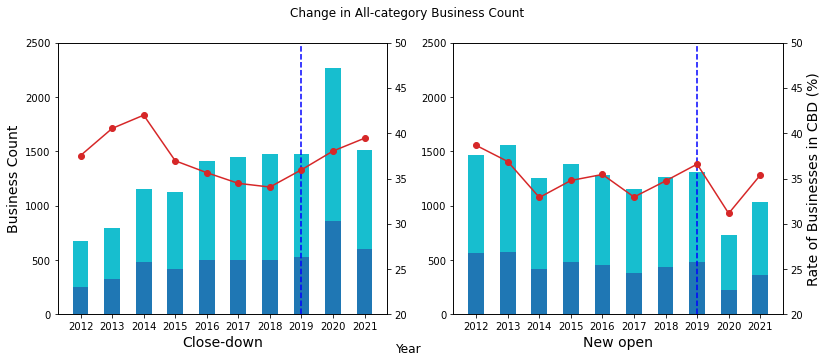

In [5]:
#(1)all businesses
fig = plt.figure(figsize=(13,5),facecolor='w')
ax = fig.add_subplot(121)
ax_o = fig.add_subplot(122)
ax.bar(years[1:],[count('close', y,philly)[0] for y in years[1:]],color="tab:cyan", width= 0.5 )
ax.bar(years[1:],[count('close', y,philly)[1] for y in years[1:]],color="tab:blue", width= 0.5 )
ax.set_xlabel("Close-down",fontsize=14)
ax.set_ylabel("Business Count",fontsize=14)
ax.set_ylim(0,2500)
ax2=ax.twinx()
ax2.plot(years[1:],[count('close', y,philly)[2] for y in years[1:]], color="tab:red",marker="o" )
ax2.set_ylim(20,50)
ax.set_xticks(years[1:], minor=False)
ax_o.bar(years[1:],[count('open', y,philly)[0] for y in years[1:]],color="tab:cyan", width= 0.5 )
ax_o.bar(years[1:],[count('open', y,philly)[1] for y in years[1:]],color="tab:blue", width= 0.5 )
ax_o.set_xlabel("New open",fontsize=14)
#ax_o.set_ylabel("Opened Businesses Count",fontsize=14)
ax_o.set_ylim(0,2500)
ax2=ax_o.twinx()
ax2.plot(years[1:],[count('open', y,philly)[2] for y in years[1:]], color="tab:red",marker="o" )
ax2.set_ylabel("Rate of Businesses in CBD (%)",fontsize=14)
ax2.set_ylim(20,50)
ax_o.set_xticks(years[1:], minor=False)

ax.vlines(2019, 0, 2500, linestyles='--', color='b')
ax_o.vlines(2019, 0, 2500, linestyles='--', color='b')

fig.suptitle(f'Change in All-category Business Count ')
fig.supxlabel('Year')
plt.savefig("../output/yelp.png")
plt.show()

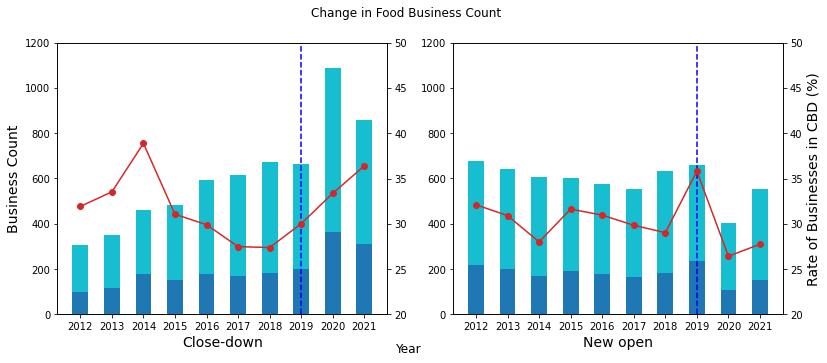

In [6]:
#(2) Food Businesses
food= philly_geo[philly_geo.categories.notna()][philly_geo[philly_geo.categories.notna()].categories.str.contains('food|restaurant|bar|cafe|Grocery', case=False)]
fig = plt.figure(figsize=(13,5),facecolor='w')
ax = fig.add_subplot(121)
ax_o = fig.add_subplot(122)
ax.bar(years[1:],[count('close', y,food)[0] for y in years[1:]],color="tab:cyan", width= 0.5 )
ax.bar(years[1:],[count('close', y,food)[1] for y in years[1:]],color="tab:blue", width= 0.5 )
ax.set_xlabel("Close-down",fontsize=14)
ax.set_ylabel("Business Count",fontsize=14)
ax.set_ylim(0,1200)
ax2=ax.twinx()
ax2.plot(years[1:],[count('close', y,food)[2] for y in years[1:]], color="tab:red",marker="o" )
ax2.set_ylim(20,50)
ax.set_xticks(years[1:], minor=False)
ax_o.bar(years[1:],[count('open', y,food)[0] for y in years[1:]],color="tab:cyan", width= 0.5 )
ax_o.bar(years[1:],[count('open', y,food)[1] for y in years[1:]],color="tab:blue", width= 0.5 )
ax_o.set_xlabel("New open",fontsize=14)
ax_o.set_ylim(0,1200)
ax2=ax_o.twinx()
ax2.plot(years[1:],[count('open', y,food)[2] for y in years[1:]], color="tab:red",marker="o" )
ax2.set_ylabel("Rate of Businesses in CBD (%)",fontsize=14)
ax2.set_ylim(20,50)
ax_o.set_xticks(years[1:], minor=False)

ax.vlines(2019, 0, 1200, linestyles='--', color='b')
ax_o.vlines(2019, 0, 1200, linestyles='--', color='b')

fig.suptitle(f'Change in Food Business Count ')
fig.supxlabel('Year')
plt.savefig("../output/yelp_food.png")
plt.show()

### 2.Business licenses data

In [7]:
shape_map_path = r"../data/business_licenses/business_licenses.shp"
shape_map = gpd.read_file(shape_map_path)
license = shape_map.to_crs(epsg=4326)  # EPSG 4326 = WGS84 = https://epsg.io/4326
food_l = license.licensetyp.str.contains('Food', case=False)
food_license = license[food_l]
food_license.reset_index(inplace=True, drop=True)
food_license.loc[:, 'longitude'] = food_license.geometry.x
food_license.loc[:, 'latitude'] = food_license.geometry.y
food_license['open'] = food_license.initialiss.str[:4]
food_license['close'] = food_license.inactiveda.str[:4]
food_license = food_license[(food_license.latitude.notna()) & (food_license.longitude.notna())]
food_license['distance'] = food_license.apply(lambda x: distance.distance((x['latitude'], x['longitude']), center).km, axis=1) 
food_license['is_cbd'] = food_license.apply(lambda x: 1 if x['distance'] <= 2 else 0, axis=1) 

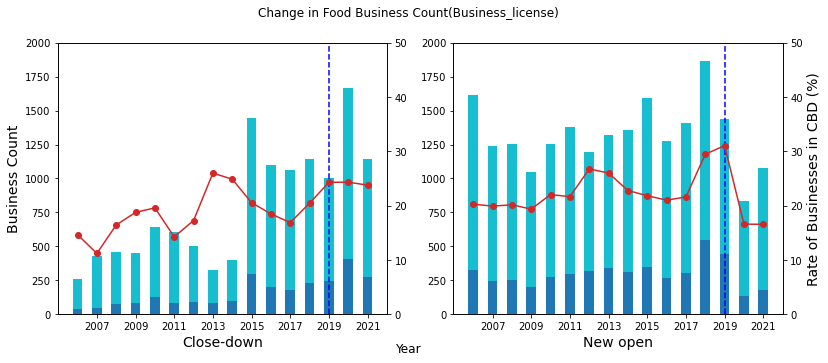

In [8]:
#use business license data
x = [i for i in range(2006,2022)]
y1_all = [len(food_license[food_license.close==str(y)]) for y in x]
y1_cbd = [sum(food_license[food_license.close==str(y)].is_cbd) for y in x]
y1_all.pop(6)
y1_all.insert(6, (y1_all[5]+y1_all[7])/2)
y1_cbd.pop(6)
y1_cbd.insert(6, (y1_cbd[5]+y1_cbd[7])/2)
y1 =[100*sum(food_license[food_license.close==str(y)].is_cbd)/len(food_license[food_license.close==str(y)])
        for y in x]
y2 = [100*sum(food_license[food_license.open==str(y)].is_cbd)/len(food_license[food_license.open==str(y)])
        for y in x]
fig = plt.figure(figsize=(13,5),facecolor='w')
ax = fig.add_subplot(121)
ax_o = fig.add_subplot(122)
ax.bar(x,y1_all,color="tab:cyan", width= 0.5 )
ax.bar(x,y1_cbd,color="tab:blue", width= 0.5 )

ax.set_xlabel("Close-down",fontsize=14)
ax.set_ylabel("Business Count",fontsize=14)
ax.set_ylim(0,2000)
ax2=ax.twinx()
ax2.plot(x,y1, color="tab:red",marker="o" )

ax2.set_ylim(0,50)
ax.set_xticks(x[1::2], minor=False)
ax_o.bar(x,[len(food_license[food_license.open==str(y)]) for y in x],color="tab:cyan", width= 0.5 )
ax_o.bar(x,[sum(food_license[food_license.open==str(y)].is_cbd) for y in x],color="tab:blue", width= 0.5 )
ax_o.set_xlabel("New open",fontsize=14)
ax_o.set_ylim(0,2000)
ax2=ax_o.twinx()
ax2.plot(x,y2, color="tab:red",marker="o" )
ax2.set_ylabel("Rate of Businesses in CBD (%)",fontsize=14)
ax2.set_ylim(0,50)
ax_o.set_xticks(x[1::2], minor=False)
ax.vlines(2019, 0, 2000, linestyles='--', color='b')
ax_o.vlines(2019, 0, 2000, linestyles='--', color='b')

fig.suptitle(f'Change in Food Business Count(Business_license)')
fig.supxlabel('Year')
plt.savefig("../output/licenses.png")
plt.show()

## Running Difference-in-Difference model

In [33]:
with open('../output/pop.csv', "r") as p:
    pop = pd.read_csv(p)
    
shape_map = gpd.read_file('../data/Philadelphia_Census_Tracts_2010/Philadelphia_Census_Tracts_2010.shp')
gdf = shape_map.to_crs(epsg=4326)  
area = gdf[['TRACTCE10','SHAPE_AREA']]
area['tr'] = area.TRACTCE10.astype(float)/100

In [34]:
l = [pop]
for y in range(1993,2009):
    df = pop[pop.yr==2009]
    df['yr'] = y
    l.append(df)
for y in range(2020,2023):
    df = pop[pop.yr==2019]
    df['yr'] = y
    l.append(df)
pop = pd.concat(l,ignore_index=True)

### With Yelp data

In [309]:
status_col =['close_%s'%(y) for y in years[1:]]+['open_%s'%(y) for y in years[1:]]
df_yelp =food[['tract','block', 'geoid','is_cbd','postal_code'] + status_col]
df_tract = df_yelp.groupby(['tract'])['close_2012',
 'close_2013','close_2014','close_2015','close_2016','close_2017','close_2018','close_2019','close_2020',
 'close_2021','open_2012','open_2013','open_2014','open_2015','open_2016','open_2017','open_2018','open_2019',
 'open_2020','open_2021'].apply(lambda x : x.astype(int).sum())
df_tract.reset_index(inplace=True)
df_tract = pd.wide_to_long(df_tract, ["close_", "open_"], i="tract", j="year")
df_tract.reset_index(inplace=True)

df_tract['is_cbd'] = df_tract.apply(lambda row: 1 if row.tract in cbd_census else 0,axis =1)
df_tract['post_covid'] = df_tract.apply(lambda x: 1 if x.year>=2020 else 0, axis=1)

#creating interaction variable
df_tract['DID'] = df_tract.apply( lambda x: 1 if (x['is_cbd']==1) and (x['post_covid']==1) else 0, axis=1)
# create log open count
df_tract['ln(New open)'] = np.log(df_tract.open_)
df_tract['ln(Close-down)'] = np.log(df_tract.close_)
df_tract.rename({'open_':'New open','close_':'Close-down'}, axis=1, inplace=True)

df_tract['census_track'] = df_tract['tract'].astype(float)/100
df_tract['year']= df_tract.year.astype(int)
df_tract = df_tract.merge(pop, left_on = ['census_track','year'], right_on=['tr','yr'])
df_tract = df_tract.merge(area,  left_on = ['census_track'], right_on=['tr'])
df_tract['density'] = df_tract.population*1000/df_tract.SHAPE_AREA
df_tract['pop'] = df_tract.population/10000
df_tract['area']=df_tract.SHAPE_AREA/1000000
df_tract['post covid * density'] = df_tract['density']  * df_tract['post_covid'] 

In [310]:
df_tract['year']=df_tract['year'].astype(int)
df_tract['year_index'] = df_tract['year']
df_tract['tract_index'] = df_tract['TRACTCE10']
df_tract.set_index(['tract_index','year_index'],inplace=True)
df_tract.rename({'New open': 'new_open'},axis=1,inplace=True)

In [312]:
df_tract.rename({'Close-down': 'close'},axis=1,inplace=True)

In [313]:
mod = lm.PanelOLS.from_formula(''' new_open ~ 
DID + EntityEffects + TimeEffects''',df_tract)

# Specify clustering when we fit the model
clfe = mod.fit(cov_type = 'clustered', cluster_entity = True)
print(clfe)

                          PanelOLS Estimation Summary                           
Dep. Variable:               new_open   R-squared:                        0.0102
Estimator:                   PanelOLS   R-squared (Between):             -0.0354
No. Observations:                3673   R-squared (Within):               0.0189
Date:                Fri, May 06 2022   R-squared (Overall):             -0.0268
Time:                        19:36:40   Log-likelihood                   -5363.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      34.460
Entities:                         334   P-value                           0.0000
Avg Obs:                       10.997   Distribution:                  F(1,3329)
Min Obs:                      10.0000                                           
Max Obs:                       11.000   F-statistic (robust):             5.7607
                            

In [314]:
mod = lm.PanelOLS.from_formula(''' close ~ 
DID + EntityEffects + TimeEffects''',df_tract)

# Specify clustering when we fit the model
clfe = mod.fit(cov_type = 'clustered', cluster_entity = True)
print(clfe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  close   R-squared:                        0.0804
Estimator:                   PanelOLS   R-squared (Between):              0.1078
No. Observations:                3673   R-squared (Within):               0.1198
Date:                Fri, May 06 2022   R-squared (Overall):              0.1107
Time:                        19:36:57   Log-likelihood                   -6363.3
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      290.99
Entities:                         334   P-value                           0.0000
Avg Obs:                       10.997   Distribution:                  F(1,3329)
Min Obs:                      10.0000                                           
Max Obs:                       11.000   F-statistic (robust):             12.133
                            

(-5.0, 5.0)

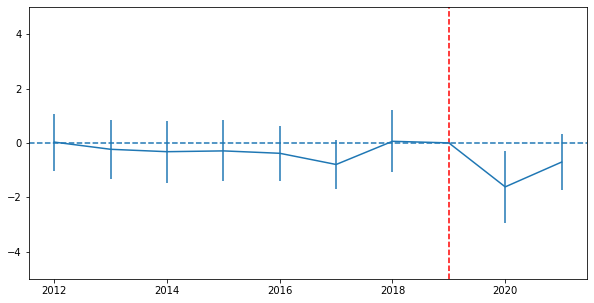

In [322]:
viz_df = df_tract

# Create our interactions by hand,
# skipping quarter 3, the last one before treatment
for i in list(range(2012,2019))+[2020,2021]:
    name = 'INX'+str(i)
    viz_df[name] = 1*df_tract.is_cbd
    viz_df.loc[viz_df['year'] != i, name] = 0

mod = lm.PanelOLS.from_formula('''new_open ~  INX2012 + INX2013 + INX2014+
 INX2015 + INX2016 + INX2017 + INX2018  + INX2020 + 
INX2021 + 
EntityEffects ''', viz_df)

# Specify clustering when we fit the model
clfe = mod.fit(cov_type = 'clustered',
cluster_entity = True)

# Get coefficients and CIs
res = pd.concat([clfe.params, clfe.std_errors], axis = 1)
# Scale standard error to CI
res['ci'] = res['std_error']*1.96

# Add our quarter values
res['year_index'] = list(range(2012,2019))+[2020,2021]
# And add our reference period back in
reference = pd.DataFrame([[0,0,0,2019]],
columns = ['parameter',
            'lower',
            'upper',
            'year_index'])
res = pd.concat([res, reference])
res = res.sort_values('year_index')
res['year'] = range(2012,2022)
# Plot the estimates as connected lines with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(x = 'year', y = 'parameter',
                    yerr = 'ci', data = res)
# Add a horizontal line at 0
plt.axhline(0, linestyle = 'dashed')
plt.axvline(2019, linestyle = 'dashed', color='red')
plt.ylim(-5,5)

(-5.0, 5.0)

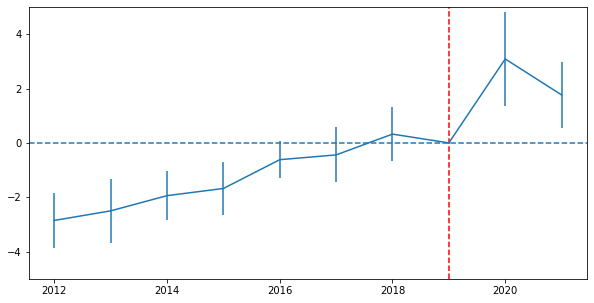

In [326]:
viz_df = df_tract

# Create our interactions by hand,
# skipping quarter 3, the last one before treatment
for i in list(range(2012,2019))+[2020,2021]:
    name = 'INX'+str(i)
    viz_df[name] = 1*df_tract.is_cbd
    viz_df.loc[viz_df['year'] != i, name] = 0

mod = lm.PanelOLS.from_formula('''close ~  INX2012 + INX2013 + INX2014+
 INX2015 + INX2016 + INX2017 + INX2018  + INX2020 + 
INX2021 + 
EntityEffects ''', viz_df)

# Specify clustering when we fit the model
clfe = mod.fit(cov_type = 'clustered',
cluster_entity = True)

# Get coefficients and CIs
res = pd.concat([clfe.params, clfe.std_errors], axis = 1)
# Scale standard error to CI
res['ci'] = res['std_error']*1.96

# Add our quarter values
res['year_index'] = list(range(2012,2019))+[2020,2021]
# And add our reference period back in
reference = pd.DataFrame([[0,0,0,2019]],
columns = ['parameter',
            'lower',
            'upper',
            'year_index'])
res = pd.concat([res, reference])
res = res.sort_values('year_index')
res['year'] = range(2012,2022)
# Plot the estimates as connected lines with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(x = 'year', y = 'parameter',
                    yerr = 'ci', data = res)
# Add a horizontal line at 0
plt.axhline(0, linestyle = 'dashed')
plt.axvline(2019, linestyle = 'dashed', color='red')
plt.ylim(-5,5)

In [68]:
# fit model with open
x = df_tract.loc[:,['is_cbd', 'post_covid','DID','post covid * density']]
y = df_tract['New open']
X2 = sm.add_constant(x)
est_o = sm.OLS(y, X2).fit(cov_type='HC2', use_t=None)
# fit model with log(open_count)
x = df_tract.loc[:,['is_cbd', 'post_covid','DID','post covid * density']][df_tract['ln(New open)']>=0]
y_ln = df_tract['ln(New open)'][df_tract['ln(New open)']>=0]
X2 = sm.add_constant(x)
est_l_o = sm.OLS(y_ln, X2).fit(cov_type='HC2', use_t=None)
# fit model with close
x = df_tract.loc[:,['is_cbd', 'post_covid','DID','post covid * density']]
y = df_tract['Close-down']
X2 = sm.add_constant(x)
est_c = sm.OLS(y, X2).fit(cov_type='HC2', use_t=None)
# fit model with log(close_count)
x = df_tract.loc[:,['is_cbd', 'post_covid','DID','post covid * density']][df_tract['ln(Close-down)']>=0]
y_ln = df_tract['ln(Close-down)'][df_tract['ln(Close-down)']>=0]
X2 = sm.add_constant(x)
est_l_c = sm.OLS(y_ln, X2).fit(cov_type='HC2', use_t=None)

In [11]:
df_tract.to_csv('../output/yelp_ct.csv', index=False)

In [38]:
stargazer = Stargazer([est_o, est_l_o, est_c, est_l_c])
stargazer.title('Regression results')
stargazer.custom_columns(['New open', 'ln(New open)', 'Close-down','ln(Close-down)'], [1, 1,1,1])
stargazer.significant_digits(3)
stargazer.covariate_order(['DID', 'post_covid', 'is_cbd', 'const','post covid * density',])
stargazer.rename_covariates({'DID': 'Post Covid * CBD', 'is_cbd': 'CBD','const':'Constant',
                             'post_covid':'Post Covid'})
stargazer.show_degrees_of_freedom(False)
stargazer.add_custom_notes(['Data Source: Yelp.com(2022)'])
stargazer.cov_spacing = 2
stargazer

In [ ]:
#print(stargazer.render_latex())

In [39]:
# fit model with open
x = df_tract.loc[:,['is_cbd', 'post_covid','DID']]
y = df_tract['New open']
X2 = sm.add_constant(x)
est_o = sm.OLS(y, X2).fit(cov_type='HC2', use_t=None)
# fit model with log(open_count)
x = df_tract.loc[:,['is_cbd', 'post_covid','DID']][df_tract['ln(New open)']>=0]
y_ln = df_tract['ln(New open)'][df_tract['ln(New open)']>=0]
X2 = sm.add_constant(x)
est_l_o = sm.OLS(y_ln, X2).fit(cov_type='HC2', use_t=None)
# fit model with close
x = df_tract.loc[:,['is_cbd', 'post_covid','DID']]
y = df_tract['Close-down']
X2 = sm.add_constant(x)
est_c = sm.OLS(y, X2).fit(cov_type='HC2', use_t=None)
# fit model with log(close_count)
x = df_tract.loc[:,['is_cbd', 'post_covid','DID']][df_tract['ln(Close-down)']>=0]
y_ln = df_tract['ln(Close-down)'][df_tract['ln(Close-down)']>=0]
X2 = sm.add_constant(x)
est_l_c = sm.OLS(y_ln, X2).fit(cov_type='HC2', use_t=None)

In [41]:
stargazer = Stargazer([est_o, est_l_o, est_c, est_l_c])
stargazer.title('Regression results')
stargazer.custom_columns(['New open', 'ln(New open)', 'Close-down','ln(Close-down)'], [1, 1,1,1])
stargazer.significant_digits(3)
stargazer.covariate_order(['DID', 'post_covid', 'is_cbd', 'const'])
stargazer.rename_covariates({'DID': 'Post Covid * CBD', 'is_cbd': 'CBD','const':'Constant',
                             'post_covid':'Post Covid'})
stargazer.show_degrees_of_freedom(False)
stargazer.add_custom_notes(['Data Source: Yelp.com(2022)'])
stargazer.cov_spacing = 2
stargazer

In [298]:
#print(stargazer.render_latex())

### With licenses data

In [118]:
df_use = food_license[['censustrac' , 'open', 'close', 'is_cbd']]
df_cen = pd.DataFrame(df_use.censustrac.value_counts())
df_cen.reset_index(inplace=True)
df_cen.rename({"index":"census_track", "censustrac": "count"}, inplace=True, axis=1)
cen_trac = df_use.censustrac.unique()
df_use['close'][df_use.close=='3013'] = '2013'

In [238]:
c_lst = []
for c in cen_trac:
    df = pd.DataFrame(df_use[df_use.censustrac==c].open.value_counts())
    df.reset_index(inplace=True)
    df.rename({"index":"year","open":"open_count"}, inplace=True, axis=1)
    df['census_track'] = c
    df['is_cbd'] = df_use[df_use.censustrac==c].is_cbd.max()
    
    c_lst.append(df)
data = pd.concat(c_lst, ignore_index=True)

data['post_covid'] = data.apply(lambda x: 1 if int(x.year)>=2020 else 0, axis=1)
#creating interaction variable
data['DID'] = data.apply( lambda x: 1 if (x['is_cbd']==1) and (x['post_covid']==1) else 0, axis=1)
# create log open count
data['open_ln'] = np.log(data.open_count)

census_dic = dict(data.census_track.value_counts())

c_lst = []
for c in cen_trac:
    df = pd.DataFrame(df_use[df_use.censustrac==c].close.value_counts())
    df.reset_index(inplace=True)
    df.rename({"index":"year","close":"close_count"}, inplace=True, axis=1)
    df['census_track'] = c
    df['is_cbd'] = df_use[df_use.censustrac==c].is_cbd.max()
    
    c_lst.append(df)
data2 = pd.concat(c_lst, ignore_index=True)
data2['post_covid'] = data2.apply(lambda x: 1 if int(x.year)>=2020 else 0, axis=1)

#creating interaction variable
data2['DID'] = data2.apply( lambda x: 1 if (x['is_cbd']==1) and (x['post_covid']==1) else 0, axis=1)
# create log open count
data2['close_ln'] = np.log(data2.close_count)

census_dic2 = dict(data2.census_track.value_counts())
data['census'] = data.apply(lambda x: str(int(float(x.census_track) * 100)), axis=1)
data2['census'] = data2.apply(lambda x: str(int(float(x.census_track) * 100)), axis=1)

data.rename({'open_count' :'New open'}, inplace=True,axis='columns')
data2.rename({'close_count' :'Close-down'}, inplace=True,axis='columns')

data['census_trac']= data.census_track.astype(float)
data2['census_trac']= data2.census_track.astype(float)
data['year']= data.year.astype(int)
data2['year']= data2.year.astype(int)

data = data.merge(pop,left_on = ['census_trac','year'], right_on=['tr','yr'])
data2 = data2.merge(pop, left_on = ['census_trac','year'], right_on=['tr','yr'])
data = data.merge(area,left_on = ['census_trac'], right_on=['tr'])
data2 = data2.merge(area, left_on = ['census_trac'], right_on=['tr'])
data['pop'] = data.population/1000
data2['pop'] = data2.population/1000
data['density'] = data.population*1000/data.SHAPE_AREA
data2['density'] = data2.population*1000/data.SHAPE_AREA
data = data[data.year!=2012]
data2 = data2[data2.year!=2012]
data['post covid * density'] = data['density']  * data['post_covid'] 
data2['post covid * density'] = data2['density']  * data2['post_covid'] 

In [ ]:
data.to_csv('../output/bl_ct.csv', index=False)
data2.to_csv('../output/bl_ct2.csv', index=False)

In [239]:
for k in data2['census_track'].unique():
    if census_dic2[k] <= 5:
        data2.drop(data2[data2['census_track'] == k].index, inplace = True)
for k in data['census_track'].unique():
    if census_dic[k] <= 20: #10
        data.drop(data[data['census_track'] == k].index, inplace = True)

In [127]:
import linearmodels as lm

In [241]:
data['year']=data['year'].astype(int)
data2['year']=data2['year'].astype(int)
data['year_index'] = data['year']
data2['year_index'] = data2['year']
data['tract_index'] = data['TRACTCE10']
data2['tract_index'] = data2['TRACTCE10']
data.set_index(['tract_index','year_index'],inplace=True)
data2.set_index(['tract_index','year_index'],inplace=True)
data.rename({'New open': 'new_open'},axis=1,inplace=True)
data2.rename({'Close-down': 'close'},axis=1,inplace=True)

In [297]:
mod = lm.PanelOLS.from_formula(''' close ~ 
DID + EntityEffects + TimeEffects''',data2)

# Specify clustering when we fit the model
clfe = mod.fit(cov_type = 'clustered', cluster_entity = True)
print(clfe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  close   R-squared:                        0.0268
Estimator:                   PanelOLS   R-squared (Between):              0.0577
No. Observations:                4201   R-squared (Within):               0.0418
Date:                Fri, May 06 2022   R-squared (Overall):              0.0522
Time:                        19:21:32   Log-likelihood                   -9302.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      105.44
Entities:                         348   P-value                           0.0000
Avg Obs:                       12.072   Distribution:                  F(1,3836)
Min Obs:                       5.0000                                           
Max Obs:                       18.000   F-statistic (robust):             13.314
                            

In [146]:
mod = lm.PanelOLS.from_formula(''' new_open ~ 
DID + EntityEffects + TimeEffects''',data)

# Specify clustering when we fit the model
clfe = mod.fit(cov_type = 'clustered', cluster_entity = True)
print(clfe)

                          PanelOLS Estimation Summary                           
Dep. Variable:               new_open   R-squared:                        0.0116
Estimator:                   PanelOLS   R-squared (Between):             -0.0478
No. Observations:                4460   R-squared (Within):               0.0148
Date:                Fri, May 06 2022   R-squared (Overall):             -0.0149
Time:                        18:06:57   Log-likelihood                  -1.3e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      49.517
Entities:                         219   P-value                           0.0000
Avg Obs:                       20.365   Distribution:                  F(1,4212)
Min Obs:                      10.0000                                           
Max Obs:                       27.000   F-statistic (robust):             10.700
                            

In [156]:
placebo_df = data[(data['post_covid'] ==0)]
# Transform dataframe to match the equation
placebo_df['fake_after1'] = placebo_df['year'] > 2018
placebo_df['fake_after2'] = placebo_df['year'] > 2016
placebo_df['fake_treated1'] = 1*(placebo_df['is_cbd'] & placebo_df['fake_after1'])
placebo_df['fake_treated2'] = 1*(placebo_df['is_cbd'] & placebo_df['fake_after2'])

In [157]:
mod1 = lm.PanelOLS.from_formula(''' new_open ~ 
fake_treated1 + EntityEffects + TimeEffects''',placebo_df)
mod2 = lm.PanelOLS.from_formula(''' new_open ~ 
fake_treated2 + EntityEffects + TimeEffects''',placebo_df)
# Specify clustering when we fit the model
clfe1 = mod1.fit(cov_type = 'clustered', cluster_entity = True)
clfe2 = mod2.fit(cov_type = 'clustered', cluster_entity = True)
print(clfe1)
print(clfe2)

                          PanelOLS Estimation Summary                           
Dep. Variable:               new_open   R-squared:                        0.0059
Estimator:                   PanelOLS   R-squared (Between):              0.0187
No. Observations:                3749   R-squared (Within):               0.0020
Date:                Fri, May 06 2022   R-squared (Overall):              0.0092
Time:                        18:10:50   Log-likelihood                -1.111e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      20.863
Entities:                         219   P-value                           0.0000
Avg Obs:                       17.119   Distribution:                  F(1,3504)
Min Obs:                       7.0000                                           
Max Obs:                       24.000   F-statistic (robust):             2.0839
                            

(-20.0, 20.0)

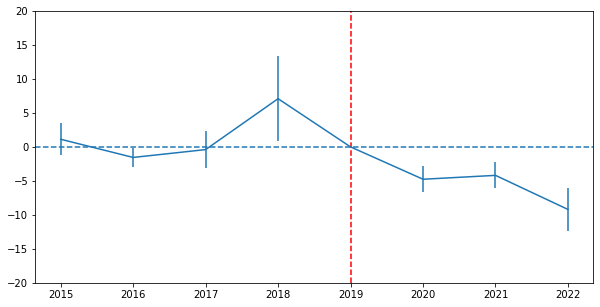

In [323]:
viz_df = data

# Create our interactions by hand,
# skipping quarter 3, the last one before treatment
for i in list(range(2015,2019))+[2020,2021,2022]:
    name = 'INX'+str(i)
    viz_df[name] = 1*data.is_cbd
    viz_df.loc[viz_df['year'] != i, name] = 0

mod = lm.PanelOLS.from_formula('''new_open ~ 
 INX2015 + INX2016 + INX2017 + INX2018  + INX2020 + 
INX2021 + INX2022 + 
EntityEffects ''', viz_df)

# Specify clustering when we fit the model
clfe = mod.fit(cov_type = 'clustered',
cluster_entity = True)

# Get coefficients and CIs
res = pd.concat([clfe.params, clfe.std_errors], axis = 1)
# Scale standard error to CI
res['ci'] = res['std_error']*1.96

# Add our quarter values
res['year_index'] = list(range(2015,2019))+[2020,2021,2022]
# And add our reference period back in
reference = pd.DataFrame([[0,0,0,2019]],
columns = ['parameter',
            'lower',
            'upper',
            'year_index'])
res = pd.concat([res, reference])
res = res.sort_values('year_index')
res['year'] = range(2015,2023)
# Plot the estimates as connected lines with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(x = 'year', y = 'parameter',
                    yerr = 'ci', data = res)
# Add a horizontal line at 0
plt.axhline(0, linestyle = 'dashed')
plt.axvline(2019, linestyle = 'dashed', color='red')
plt.ylim(-20,20)

(-10.0, 10.0)

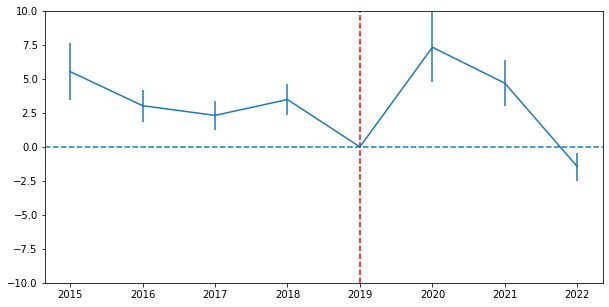

In [325]:
viz_df = data2

# Create our interactions by hand,
# skipping quarter 3, the last one before treatment
for i in list(range(2015,2019))+[2020,2021,2022]:
    name = 'INX'+str(i)
    viz_df[name] = 1*data2.is_cbd
    viz_df.loc[viz_df['year'] != i, name] = 0

mod = lm.PanelOLS.from_formula('''close ~ 
 INX2015 + INX2016 + INX2017 + INX2018  + INX2020+ 
INX2021 + INX2022 + 
EntityEffects ''', viz_df)

# Specify clustering when we fit the model
clfe = mod.fit(cov_type = 'clustered',
cluster_entity = True)

# Get coefficients and CIs
res = pd.concat([clfe.params, clfe.std_errors], axis = 1)
# Scale standard error to CI
res['ci'] = res['std_error']*1.96

# Add our quarter values
res['year_index'] = list(range(2015,2019))+[2020,2021,2022]
# And add our reference period back in
reference = pd.DataFrame([[0,0,0,2019]],
columns = ['parameter',
            'lower',
            'upper',
            'year_index'])
res = pd.concat([res, reference])
res = res.sort_values('year_index')
res['year'] = range(2015,2023)
# Plot the estimates as connected lines with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(x = 'year', y = 'parameter',
                    yerr = 'ci', data = res)
# Add a horizontal line at 0
plt.axhline(0, linestyle = 'dashed')
plt.axvline(2019, linestyle = 'dashed', color='red')
plt.ylim(-10,10)

In [50]:
from linearmodels import PanelOLS

In [108]:
# fit model 
x = data.loc[:,['is_cbd', 'post_covid','DID','post covid * density']]
y = data['New open']
#model = LinearRegression().fit(x, y)
X2 = sm.add_constant(x)
est_o = PanelOLS(y, X2,entity_effects=True,time_effects=True,drop_absorbed=True).fit()
# fit model with log(New open)
x = data.loc[:,['is_cbd', 'post_covid','DID','post covid * density']]
y_ln = data['open_ln']
#model_ln = LinearRegression().fit(x, y_ln)
X2 = sm.add_constant(x)
est_l_o = PanelOLS(y_ln, X2,entity_effects=True,time_effects=True,drop_absorbed=True).fit()
# fit model 
x = data2.loc[:,['is_cbd', 'post_covid','DID','post covid * density']]
y = data2['Close-down']
#model = .fit(x, y)
X2 = sm.add_constant(x)
est_c = PanelOLS(y, X2,entity_effects=True,time_effects=True,drop_absorbed=True).fit()
# fit model with log(Close-down)
x = data2.loc[:,['is_cbd', 'post_covid','DID','post covid * density']]
y_ln = data2['close_ln']
X2 = sm.add_constant(x)
est_l_c = PanelOLS(y_ln, X2,entity_effects=True,time_effects=True,drop_absorbed=True).fit()

In [112]:
stargazer = Stargazer([est_o, est_l_o, est_c, est_l_c])
stargazer.title('Regression results')
stargazer.custom_columns(['New Open', 'ln(New open)', 'Close-down','ln(Close-down)'], [1, 1,1,1])
stargazer.significant_digits(2)
stargazer.covariate_order(['DID', 'post_covid', 'is_cbd','post covid * density','const'])
stargazer.rename_covariates({'DID': 'Post Covid * CBD', 'is_cbd': 'CBD',
                              'const':'Constant','post_covid':'Post Covid'})
stargazer.show_degrees_of_freedom(False)
stargazer.add_custom_notes(['Data Source: Business Licenses - Philadelphia (2022)'])
stargazer.cov_spacing = 2
stargazer

ValueError: Please use trained OLS models as inputs

In [287]:
#print(stargazer.render_latex())

In [47]:
# fit model 
x = data.loc[:,['is_cbd', 'post_covid','DID']]
y = data['New open']
#model = LinearRegression().fit(x, y)
X2 = sm.add_constant(x)
est_o = sm.OLS(y, X2).fit(cov_type='HC2', use_t=None)
# fit model with log(New open)
x = data.loc[:,['is_cbd', 'post_covid','DID']]
y_ln = data['open_ln']
model_ln = LinearRegression().fit(x, y_ln)
X2 = sm.add_constant(x)
est_l_o = sm.OLS(y_ln, X2).fit(cov_type='HC2', use_t=None)
# fit model 
x = data2.loc[:,['is_cbd', 'post_covid','DID']]
y = data2['Close-down']
model = LinearRegression().fit(x, y)
X2 = sm.add_constant(x)
est_c = sm.OLS(y, X2).fit(cov_type='HC2', use_t=None)
# fit model with log(Close-down)
x = data2.loc[:,['is_cbd', 'post_covid','DID']]
y_ln = data2['close_ln']
model_ln = LinearRegression().fit(x, y_ln)
X2 = sm.add_constant(x)
est_l_c = sm.OLS(y_ln, X2).fit(cov_type='HC2', use_t=None)

In [48]:
stargazer = Stargazer([est_o, est_l_o, est_c, est_l_c])
stargazer.title('Regression results')
stargazer.custom_columns(['New Open', 'ln(New open)', 'Close-down','ln(Close-down)'], [1, 1,1,1])
stargazer.significant_digits(2)
stargazer.covariate_order(['DID', 'post_covid', 'is_cbd','const'])
stargazer.rename_covariates({'DID': 'Post Covid * CBD', 'is_cbd': 'CBD',
                              'const':'Constant','post_covid':'Post Covid'})
stargazer.show_degrees_of_freedom(False)
stargazer.add_custom_notes(['Data Source: Business Licenses - Philadelphia (2022)'])
stargazer.cov_spacing = 2
stargazer

In [ ]:
#print(stargazer.render_latex())